## Price and Time Series Regression Project - Predicting Bulldozer prices at auction

This project uses Python based Machine Learning (ML) to build a model capable of predicting future bulldozer prices at auction.  Given previous sales data attributes. The data is sourced from from the Kaggle Bluebook for Bulldozers competition. The Python libraries used are from Scikit-learn, Pandas, NumPy, Matplotlib and Seaborn.
The end results will include a model that has been tuned, including feature importance, cross validation, metric reporting and visual representation.

![](6-step-ml-framework.png)

### 1. Problem definition

> Predict the future sale price of a bulldozer, given its characteristics and previous examples of similar bulldozers sales?

### 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

Time series:  A series of dates (auction sales over a specified time) with different data points

There are 3 main datasets:

- Train.csv is the training set, which contains data through the end of 2011.
- Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012.
- Test.csv is the test set, which contains data from May 1, 2012 - November 2012.

### 3. Evaluation

The evaluation metric is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluationk: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The  goal for this project will be to build a machine learning model which minimizes RMSLE to 0.3 or less

### 4. Feautures 

Kaggle provides a data dictionary detailing all of the features of the dataset.  This includes 54 features related to the sales of Bulldozers at auction.  You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

#### 5.  Modeling: Tools used

In [1]:
# (EDA) Exploring Data Analysis and plotting libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import warnings
from sklearn.exceptions import DataConversionWarning

# Models from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.preprocessing import StandardScaler

# Model Evaluations
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

## Data

#### Importing the data
- For time series regression
    - The data must be parsed when imported to use the DatetimeIndex API (format for easy manipulation)
    - The data must be sorted (easier for time series)

In [2]:
df = pd.read_csv("data/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### EDA (Exploratory Data Analysis)
- Does that data contain missing values
- Does the data (Dtype) have categorical data that needs to be converted to a number
- Review the data dictionary attributes and definitions

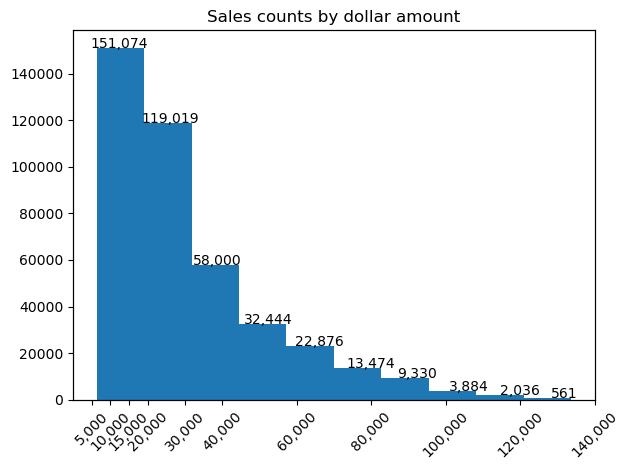

In [3]:
# See a distribution of price.  What is the most requently ocurring prices
# df.SalePrice.plot.hist()
# Calculate the frequency counts
counts, bins = np.histogram(df.SalePrice)

# Plot the histogram
plt.hist(bins[:-1], bins, weights=counts)

# Hide the original x-axis values
plt.gca().axes.get_xaxis().set_ticks([])

# Add additional x-axis
ax2 = plt.twiny()
new_xticks = [5000, 10000, 15000, 20000, 30000, 40000, 60000, 80000, 100000, 120000, 140000]
ax2.set_xticks(new_xticks)  # Set the ticks on the new x-axis
ax2.xaxis.tick_bottom()
ax2.xaxis.set_label_position('bottom')

# Format x-axis labels with thousands comma
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
ax2.xaxis.set_major_formatter(formatter)

# Rotate x-axis labels for better visibility
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)

# Show frequency counts on each bar with thousands comma
for i in range(len(bins)-1):
    plt.text(bins[i], counts[i], '{:,.0f}'.format(counts[i]))

# Add title
plt.title("Sales counts by dollar amount")

plt.tight_layout()  # Adjust the layout
plt.show()

In [4]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()
# See what % of the data is missing per column (Independant variable)
df_tmp.isnull().sum()/len(df_tmp)
# How many rows/columns + what are the data types
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

### Data : Feature Engineering
- Create custom date columns (enable for year, month, quarter etc. analysis)
- Create custom _is_missing columns
    - Columns added to keep track of when data has been added, where previously missing 

### Data : Clean-up
- Turn objects into usable numeric catagory values
- Fill missing values (numeric and non-numeric)
- Verify all values are converted
- Verify no missing data

In [5]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    
    # Ensure the 'saledate' column is in datetime format
    df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')

    date_df = pd.DataFrame({
        "saleYear": df.saledate.dt.year,
        "saleMonth": df.saledate.dt.month,
        "saleDay": df.saledate.dt.day,
        "saleDayOfWeek": df.saledate.dt.dayofweek,
        "saleDayOfYear": df.saledate.dt.dayofyear,
        "saleQuarter": df.saledate.dt.quarter
    })
    #  date_df is a new DataFrame where each series (or column) is created from the df.saledate.dt attributes. When you use pd.concat([df, date_df], axis=1), it concatenates df and date_df side by side (i.e., column-wise). So, all the series in date_df will become individual columns in the concatenated DataFrame, not an object of columns.
    # Concatenate the original DataFrame with the new date DataFrame
    df = pd.concat([df, date_df], axis=1) 

    # Optional keep or drop since we already have the dat info we need
    # df.drop("saledate", axis=1, inplace=True)


    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a new binary column which tells us if the data was missing or not
                # True= We injected the value and it was previously missing
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())

        # Fill categorical missing data + turn categories into numbers
        # IF NOT numeric
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # pd.Categorical turns the values/content for that row into [index values] of the category
            # Turn categories values into numbers using .codes and add +1 to negate the missing values of -1
            df[label] = pd.Categorical(content).codes+1

    return df

# Process the test data
df_tmp = preprocess_data(df_tmp)
df_tmp.head(1)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,1,...,True,True,True,True,True,False,False,False,True,True


### Data : Validate the clean-up was successful

In [6]:
# How to save .csv to .csv
df_tmp.to_csv("data/train1_tmp.csv",
              index=False)
# Import preprocessed data
df_tmp = pd.read_csv("data/train1_tmp.csv",
                     low_memory=False)

# These are a few ways to check
df_tmp.info()
df_tmp.head().T
df_tmp.isna().sum()
df_tmp.head()
len(df_tmp)
# Check to see that all dtypes are numeric
# All values are now numeric and object -> int8
df_tmp.info()
# Check if there's any null numeric values
# No labels (no column names) will print if successful
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 106 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(47), float64(3), int64(56)
memory usage: 204.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 106 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(47), float64(3), int64(56)
memory usage: 204.3 MB


#### Feature Importance

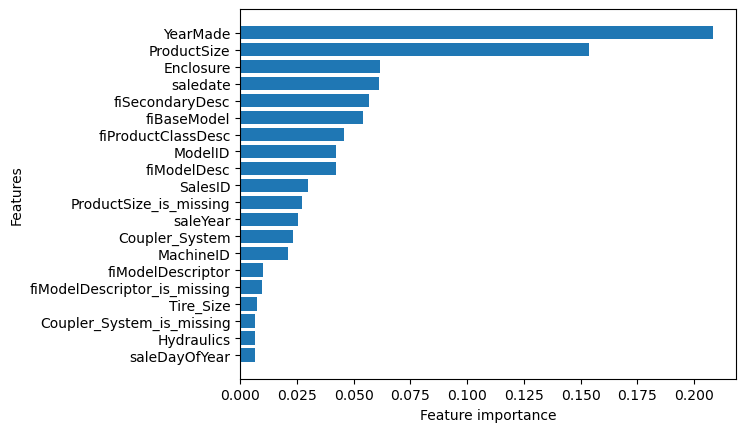

In [7]:
warnings.filterwarnings(action='ignore', category=UserWarning, module="sklearn")

df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

# Most ideal hyperparamters
# use max_samples=None = all 410k samples
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible
# Fit the ideal model
ideal_model.fit(X_train, y_train)

# Scores for ideal_model (trained on all the data)
ideal_model.feature_importances_

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))

    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

plot_features(X_train.columns, ideal_model.feature_importances_)

df["Enclosure"].value_counts();

### Modeling : Which models make sense
- This is regression(finding a number).  Use the sklearn maps to identify best models
- EnsembleRegressors are used to combine the predictions of several base estimators
    - RandomForestRegressor: decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting 
- Using 10K sample size for high level comparison (412K sample will take too long)

![](models_scikit_learn.png)

### Modeling : Splitting Test and Training data

![](test_and_train.png)

In [8]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Randomly sample 10000 instances from your training set
df_train = df_tmp[df_tmp.saleYear != 2012].sample(n=10000, random_state=42)
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice

# Fit the scaler to the training data and transform it
X_train = scaler.fit_transform(X_train)

# Randomly sample 10000 instances from your validation set
df_val = df_tmp[df_tmp.saleYear == 2012].sample(n=10000, random_state=42)
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

# Transform the validation data
X_valid = scaler.transform(X_valid)

len(df_val), len(df_train)

(10000, 10000)

### Modeling:  Fit and Score the models (High Level)

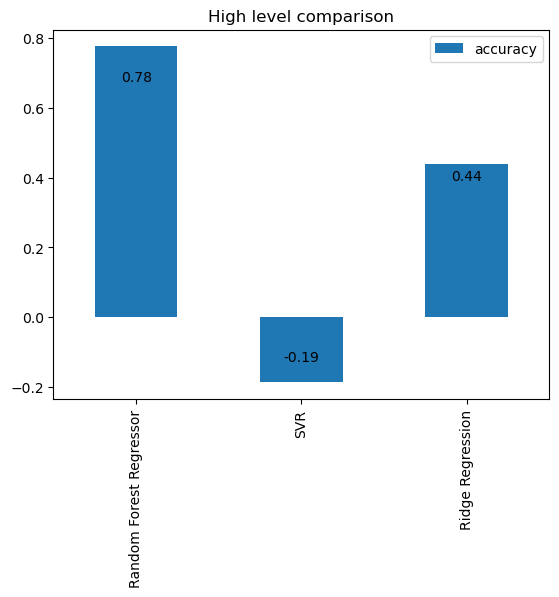

In [9]:
# Put models in a dictionary
models = {"Random Forest Regressor": RandomForestRegressor(n_jobs=-1),
          "SVR": svm.SVR(kernel='rbf', C=1.0, epsilon=0.1),
          "Ridge Regression": linear_model.Ridge(alpha=1.0, solver='auto')}
l = []
# Create a function to fit and score models
def fit_and_score(models, X_train, X_valid, y_train, y_valid):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_valid : testing data (no labels)
    y_train : training labels
    y_valid : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}

    for key, model in models.items():
        model.fit(X_train, y_train)
        model_scores[key] = model.score(X_valid, y_valid)
    return model_scores
    
model_scores = fit_and_score(models, X_train, X_valid, y_train, y_valid)
model_compare = pd.DataFrame(model_scores, index=["accuracy"])

ax = model_compare.T.plot(kind='bar') 
ax.set_title("High level comparison")

# Show accuracy scores on the bar graph
for p in ax.patches:
    ax.annotate(text=np.round(p.get_height(), decimals=2),
                xy=(p.get_x()+p.get_width()/2., p.get_height()/1.2),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')

### Modeling : Evaluation function (RMSLE) root mean square log error, r^2, (MAE) mean absolute error
https://scikit-learn.org/stable/modules/model_evaluation.html
- Mean_absolute_error:  How far each of your model's predictions are off.  Then on average how far off is the predicted value
    - (predicted value - actual) / n  : non-negative floating point. The best value is 0.0
- Mean_squared_log_error:  predicted values - actual (both squared).  Squaring amplifies this difference which makes the difference way more
    - (predicted value - actual)**2 / n : A non-negative floating point value (the best value is 0.0)
- R^2 (coefficient of determination): Measure of how well your model can predict the outcome based on the input variables. The closer R2
 is to 1, the better the model is at predicting. The closer it is to 0, the worse it is at predicting.

In [10]:
def rmsle(y_test, y_preds):
    """
    Caculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    # We expect smaller pool (12k vs 400k) from validatoin set to score (higher) worse.  If not = overfitting
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

# Cutting down on the max number of samples each estimator can see improves training time
model.fit(X_train, y_train)
show_scores(model)

{'Training MAE': 2319.768519,
 'Valid MAE': 8354.449626999998,
 'Training RMSLE': 0.12121333415161274,
 'Valid RMSLE': 0.3347222177474384,
 'Training R^2': 0.9736246948968469,
 'Valid R^2': 0.7765780381960898}

### Modeling:  Tune-up the model with Cross-Validation
- Search: 'mode_name' + hyper parameter tuning
- Using RandomizedSearchCV for hyperparameter tuning

#### Improved tuning w/ n_iter=100 and all 412K sample
- The goal for this project will be to build a machine learning model which minimizes RMSLE to 0.3 or less
- Currently better than the target goals

### Experiments:  Importing test data - Transform new .CSV to best match our training data

In [11]:
df_test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=["saledate"])
df_test.saledate[:5]

0   2012-05-03
1   2012-05-10
2   2012-05-10
3   2012-05-10
4   2012-05-10
Name: saledate, dtype: datetime64[ns]

In [12]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    df["saleQuarter"] = df.saledate.dt.quarter

    # We removed this on the train&valid data so, to match.  This needs to be removed
    # df.drop("saledate", axis=1, inplace=True)
    # df.drop('saleQuarter', axis=1, inplace=True)

    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())

        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1

    return df

# Process the test data
df_test = preprocess_data(df_test)
df_test.head(1)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,3,499,...,True,True,True,True,True,True,True,True,True,True


#### Experiments:  Which columns DON'T match across data sets
- Sets are lists with only unique values
- Add missing columns and reindex
    - If a column/s are out of order.  They need to be re-ordered/re-indexed 

In [13]:
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice

# Find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

#### Experiments: Fixing and reindexing columns to match across both sets (Training & Test)

In [14]:
# Manually adjust df_test to have auctioneerID_is_missing column...set all values to false
df_test["auctioneerID_is_missing"] = False
df_test = df_test.reindex(columns=list(X_train.columns))
# All columns must match
df_test.head(1)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,3,499,...,True,True,True,True,True,True,True,True,True,True


In [15]:
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,3,499,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,9,831,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,9,1177,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,9,287,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,9,566,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,126,713,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,126,186,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,126,325,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,126,325,...,False,False,False,False,False,True,True,True,True,True


In [16]:
warnings.filterwarnings(action='ignore', category=UserWarning, module="sklearn")

# Most ideal hyperparamters
# use max_samples=None = all 410k samples
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible
# Fit the ideal model
ideal_model.fit(X_train, y_train)

# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)
ideal_model.feature_importances_

array([2.79173623e-02, 2.37566960e-02, 4.83364502e-02, 1.47834729e-03,
       3.90428145e-03, 1.77500079e-01, 4.27000753e-03, 1.68007978e-03,
       4.96778593e-02, 3.79480215e-02, 4.05191333e-02, 6.25632630e-02,
       5.02573181e-03, 2.20363580e-02, 1.37425442e-01, 4.47647041e-02,
       6.98372589e-03, 2.04308361e-03, 8.15015162e-03, 3.66972081e-03,
       9.36089221e-02, 9.71510941e-04, 3.29916511e-04, 7.78367590e-04,
       1.85287287e-04, 1.44058223e-03, 7.27622172e-05, 3.23221749e-04,
       9.19527966e-03, 7.54240350e-04, 2.65612730e-04, 4.44603096e-03,
       5.18558936e-03, 6.34711726e-03, 2.50297862e-03, 2.77656275e-03,
       9.60855855e-03, 9.62345114e-04, 1.67294722e-02, 5.32711641e-03,
       2.30843702e-03, 1.63270156e-03, 1.04222145e-03, 1.95460515e-03,
       7.40701925e-04, 6.19147351e-04, 7.12161564e-04, 2.54634747e-04,
       2.77177095e-03, 1.35715667e-03, 2.94920155e-04, 3.66711961e-04,
       2.29853982e-02, 3.20853071e-03, 7.73775574e-03, 4.10251328e-03,
      

### Modeling:  Predictive scoring for RM

#### RMSLE results(root mean squared log error) between the actual and predicted auction prices
- The goal for this project was to build a machine learning model which minimizes RMSLE to 0.3 or less
- Currently better than the target goals
- Training RMSLE': 0.20260988530925966

### Experiments: Make price predictions on the unknown SalesPrice of the Test data

In [17]:
test_preds = ideal_model.predict(df_test)
test_preds

array([22498.68421375, 28959.59973917, 62944.82973267, ...,
       21893.18202137, 26948.13643721, 30486.74088572])

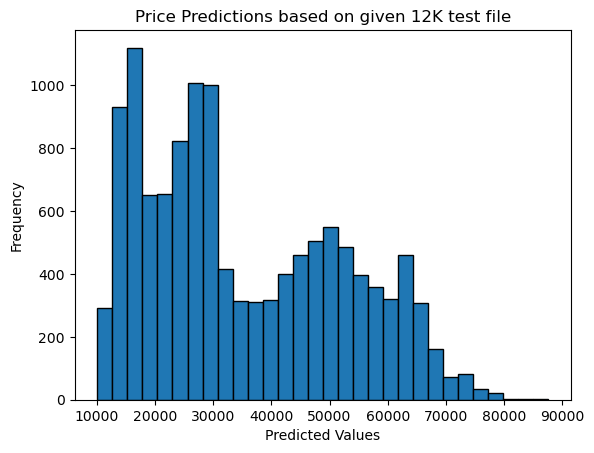

In [18]:
# Histogram of the (X)predicted price ranges based on bins and (Y) Frequency of these prices
plt.hist(test_preds, bins=30, edgecolor='black')
plt.title('Price Predictions based on given 12K test file')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.show()

In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Columns: 105 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(47), float64(1), int16(3), int32(6), int64(6), int8(42)
memory usage: 2.1 MB
